In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import collections
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from skimage.feature import hog
from skimage import exposure

import warnings
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True) 
warnings.filterwarnings("ignore", ".*check file.*")
drive_address = ""#"/content/drive/MyDrive/HW2_Vision/"

In [2]:
def Cross_Validation(data, Labels, clf, K = 5):
    # Cross validation for data and plotting ROC curve and confusion matrix
    X, y = data.copy(), Labels.copy()
    kf = KFold(n_splits = K)
    y_hat = np.array([])
    y_true = np.array([])
    for train, test in kf.split(X):
        X_train = X.loc[train]
        y_train = y[train]
        X_test = X.loc[test]
        y_test = y[test]
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        y_hat = np.concatenate((y_hat, y_predict.copy()))
        y_true = np.concatenate((y_true, y_test.copy()))
    metrics.plot_roc_curve(clf, X_test, y_test)
    plt.show()     
    clf.fit(X, y)
    print(metrics.classification_report(y_true, y_hat))
    cm = metrics.confusion_matrix(y_true, y_hat, labels = clf.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                          display_labels = clf.classes_)
    disp.plot()
    plt.show()
    return clf

In [3]:
def SVM_Grid_Search(param_grid, score, Features, Labels):
  # Tuning parameters of SVM based on grid search
  # Cross validation is also used for computing errors
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  clf = SVC(kernel = 'linear')
  grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1,
                      cv=cv, scoring=score)
  grid_result = grid.fit(Features, Labels)
  print("************* SVM *************")
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  Hyper_params = list(grid_result.best_params_.values())
  clf = SVC(C = Hyper_params[0], kernel = 'linear', probability = True)
  clf = Cross_Validation(Features, Labels, clf, 10)
  return clf

In [4]:
def Normalized_Img(img, Truncating = False):
    # This function works for both grayscale and RGB images
    # Arguments:
        #   img --- input image
        #   Truncating --- Truncating values more than 255 and less than 0 or not
    # Output:
        #   Image scaled between 0 and 255
        
    Image = img.copy()
    Image = np.float64(Image)
    
    if Truncating == True:
        Image[Image < 0] = 0
        Image[Image > 255] = 255
        
    try:
        for i in range(3):    
            Image[:,:,i] = Image[:,:,i] - np.min(Image[:,:,i])
            Image[:,:,i] = Image[:,:,i]/np.max(Image[:,:,i])*255
            
    except:
        Image = Image - np.min(Image)
        Image = Image/np.max(Image)*255  
    return Image    


In [5]:
def Gaussian_Filter(sigma):
    # Designing 2D gaussian filter with defined signma

    L = np.floor(3*sigma)    
    n = np.arange(-L, L+1, 1)
    G_X = np.exp(-pow(n,2)/(2*pow(sigma, 2)))
    G_X = G_X/sum(G_X)
    G_Y = G_X
    G_Y = np.copy(G_X)
    G_Y.shape = (len(n), 1)
    G_X.shape = (1,len(n))
    return G_Y@G_X

In [6]:
def myImageFilter(img0, h):
    # This funcion filter img0 with filter h and it also works for grayscale and RGB images
    # Arguments:
        # img0 --- input image
        # h --- filter with odd size
    # Outputs:
        # img1 --- filtered image
        
    img = img0.astype(np.float64).copy()
    filter_heights, filter_widths = h.shape
    padd_heights = (filter_heights - 1)//2
    padd_widths = (filter_widths - 1)//2
    
    # padding img0
    try:
        padded_img = np.zeros((img.shape[0] + 2*padd_heights,
                               img.shape[1] + 2*padd_widths, img.shape[2]))
    except:
        padded_img = np.zeros((img.shape[0] + 2*padd_heights,
                               img.shape[1] + 2*padd_widths))
    
    # Mirroring img0
    padded_img[padd_heights:-padd_heights, padd_widths:-padd_widths] = img.copy()
    padded_img[:, 0:padd_widths] = padded_img[:, 2*padd_widths:padd_widths:-1].copy()
    padded_img[:, -padd_widths:] = padded_img[:, -padd_widths-1:-2*padd_widths-1:-1].copy()
    padded_img[0:padd_heights, :] = padded_img[2*padd_heights:padd_heights:-1, :].copy()
    padded_img[-padd_heights:, :] = padded_img[-padd_heights-1:-2*padd_heights-1:-1, :].copy()    
    
    # filter image
    img1 = np.zeros(img.shape).astype(np.float64)
    for i in range(filter_heights):
        for j in range(filter_widths):
            img1 += padded_img[i:i+padded_img.shape[0]-2*padd_heights,
                               j:j+padded_img.shape[1]-2*padd_widths]*h[i, j]
    return img1


In [87]:
def HOG(image, resize = (128, 64), _cellSize = (8, 8),
        epsilon = 1e-5, bins = 9):
    # HOG descriptor
    # paramters:
    # resize -> the size that we resize image to    
    img = cv2.resize(image, (resize[1], resize[0]))
    img = Normalized_Img(img)

    # extracting gradient
    img_x = myImageFilter(img, np.array([[1, 2, 1],
                                          [0, 0, 0],
                                          [-1, -2, -1]]))
    
    img_y = myImageFilter(img, np.array([[1, 0, -1],
                                          [2, 0, -2],
                                          [1, 0, -1]]))
    
    
    img_magnitude = np.sqrt(img_x**2 + img_y**2)
    img_phase = cv2.phase(img_y, img_x, angleInDegrees=True)    
    
    gradient_magnitude = np.max(img_magnitude, axis = 2)
    gradient_phase = np.zeros((img_phase.shape[0], img_phase.shape[1]))
    for i in range(3):    
        gradient_phase[img_magnitude[:,:,i] == gradient_magnitude] = img_phase[img_magnitude[:,:,i] == gradient_magnitude][:, i]
    
    gradient_phase[gradient_phase >= 180] -= 180
    gradient_phase[gradient_phase == 180] = 0
    

    # quantizing unsigned gradient
    angle = 180/bins
    
    h, w = resize[0]//_cellSize[0], resize[1]//_cellSize[1]

    # HOG descriptor
    HIST = np.zeros((h, w, bins))
    for x in range(h):
        for y in range(w):

            # Extracting histogram for each cell
            hist = np.zeros(bins)
            block_phase = gradient_phase[x * _cellSize[0] : (x+1) * _cellSize[0],
                                         y * _cellSize[1] : (y+1) * _cellSize[1]]
        
            block_magnitude = gradient_magnitude[x * _cellSize[0] : (x+1) * _cellSize[0],
                                                 y * _cellSize[1] : (y+1) * _cellSize[1]]
            
            for i in range(bins):
                logic1 = block_phase < angle * (i+1)
                logic2 = block_phase >= angle * i
                logic = np.logical_and(logic1, logic2)
                temp = block_phase[logic]
                hist[i] += np.sum(((i+1)*angle - temp)/angle * block_magnitude[logic])
                hist[(i+1) % bins] += np.sum((temp - i*angle)/angle * block_magnitude[logic])

            # concat hist to HIST    
            HIST[x, y, :] = hist
    
    # Vectorizing HIST
    HOG_descriptor = np.zeros(bins * 4 * (h-1) * (w-1))
    k = 0
    for i in range(h-1):
        for j in range(w-1):
            HOG_descriptor[k*4*bins : (k+1)*4*bins] = HIST[i : i+2, j : j+2].reshape((1, 4*bins)).copy()
            HOG_descriptor[k*4*bins : (k+1)*4*bins] /= np.sqrt(np.linalg.norm(HOG_descriptor[k*4*bins : (k+1)*4*bins], 2)**2  + 1e-5)        
            k += 1
    
    # Saving features in a .csv file
    pd.DataFrame(HOG_descriptor).to_csv("HOG_descriptor.csv", index = False)
    return HOG_descriptor


def visualize_HOG(image, hog, cell_size, block_size, num_bins = 9, max_len = 5):
    # Visualizing HOG vector field thanks to quiver in matplotlib.pyplot :)
    img = image.copy()
    h, w = img.shape[0], img.shape[1]

    num_cell_h = int(h / cell_size)
    num_cell_w = int(w / cell_size)

    num_blocks_h = num_cell_h - block_size + 1
    num_blocks_w = num_cell_w - block_size + 1

    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size : cell_size*num_cell_w : cell_size],
                                 np.r_[cell_size : cell_size*num_cell_h : cell_size])

    hist = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    hist_normalized = np.sum(hist**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    
    theta = np.arange(0, np.pi, np.pi/num_bins)

    
    mesh_u = hist_normalized * np.sin(theta).reshape((1, 1, num_bins)) 
    mesh_v = hist_normalized * -np.cos(theta).reshape((1, 1, num_bins)) 

    img[:, :, [0, 2]] = img[:, :, [2, 0]]
    plt.imshow(img)

    for i in range(num_bins):
        plt.quiver(mesh_x - 1 * mesh_u[:, :, i], mesh_y - 1 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='red', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.005, angles='xy')
    plt.axis('off')
    plt.show()

  

In [ ]:
def Car_Detection(image, clf, Pyramid_Level = 5, _WinSize = (64, 64), _Stride = (16, 16),
                  probability_threshold = 0.9, h1 = 150, h2 = 200,
                  threshold1 = 3, threshold2 = 0.01, threshold3 = 2, R = 20, iterations = 2, 
                  adaptive_box = True):
    # Car detection using HOG descriptor

    # Inputs:
    # image -> input image
    
    # clf -> a svm classifier which has been learnt before passing it to the function
    
    # Pyramid_Level -> levels of gaussian pyramid 
    
    # _WinSize -> the size of input image to the classifier (usually (64 *  64))
    
    # _Stride -> the overlapped steps we use to move sliding window on the image
    
    # probability_threshold -> probability of being car in order to ignore a patch or not

    # h1, h2, threshold1, threshold2, threshold3 -> hyper parameters of "Mean Shift" clusterimg

    # R, iterations -> parameters for plotting rectangle over an object

    # adaptive_box -> if its true the size of rectangles will be based on the size of the object and it won't be a constant size.



    # Extracting points that there might be a car with high probability
    img = image.copy()

    Car_locs_x = []
    Car_locs_y = []
    for level in range(Pyramid_Level):
      for i in range((img.shape[0] - _WinSize[0])//_Stride[0] + 1):
        for j in range((img.shape[1] - _WinSize[1])//_Stride[1] + 1):
          patch = img[i * _Stride[0] : i * _Stride[0] + _WinSize[0],
                      j * _Stride[1] : j * _Stride[1] + _WinSize[1], :]
          patch_feature = hog(patch, pixels_per_cell = (8, 8), cells_per_block = (3, 3))
          patch_feature = patch_feature.reshape((1, patch_feature.shape[0]))
          patch_label = clf.predict(patch_feature)

          if patch_label == 1 and clf.predict_proba(patch_feature)[0][1] >= probability_threshold:
            Car_locs_x.append((i * _Stride[0] + _WinSize[0]//2) * 2**level)
            Car_locs_y.append((j * _Stride[1] + _WinSize[1]//2) * 2**level)

      img = myImageFilter(img, Gaussian_Filter(2)).astype(np.uint8)
      img = img[:img.shape[0]:2, :img.shape[1]:2, :]


    img = np.zeros((img.shape[0], img.shape[1]))
    for i in range(len(Car_locs_x)):
      img[Car_locs_x[i], Car_locs_y[i]] = 255



    # Removing outlier points
    locs = np.where(img == 255)
    for i in range(locs[0].shape[0]):
      if np.where(img[max(locs[0][i]-h1, 0) : locs[0][i]+h1,
                      max(locs[1][i]-h1, 0) : locs[1][i]+h1] == 255)[0].shape[0] <= threshold1:
        img[locs[0][i], locs[1][i]] = 0

    # Mean shift clustering
    locs = np.where(img == 255)
    final_locs = []
    for i in range(locs[0].shape[0]):
      x, y = locs[0][i], locs[1][i]
      logic1 = locs[0] >= x - h2
      logic2 = locs[0] <= x + h2
      logic3 = locs[1] >= y - h2
      logic4 = locs[1] <= y + h2
      logic = logic2 * logic1 * logic3 * logic4
      x1, y1 = int(np.mean(locs[0][logic])), int(np.mean(locs[1][logic]))
      while 1:
        if np.sqrt((x1 - x)**2 + (y1 - y)**2) < threshold2:
          break
        x, y = x1, y1

        logic1 = locs[0] >= x - h2
        logic2 = locs[0] <= x + h2
        logic3 = locs[1] >= y - h2
        logic4 = locs[1] <= y + h2
        logic = logic2 * logic1 * logic3 * logic4
        x1, y1 = int(np.mean(locs[0][logic])), int(np.mean(locs[1][logic]))
      final_locs.append([x1, y1])

    final_locs = np.array(final_locs)  
    dict_cars = collections.Counter(final_locs[:, 0])
    dict_cars_good_loc = np.array(list(dict_cars.keys()))[np.array(list(dict_cars.values())) > threshold3]
    logic = np.zeros(final_locs.shape[0])
    for i in range(dict_cars_good_loc.shape[0]):
      logic1 = (final_locs[:,0] == dict_cars_good_loc[i])*1
      logic = logic + logic1
    final_locs = final_locs[logic != 0]


    # plotting boxes over objects
    for iter in range(iterations):
      img = image.copy()
      final_locs_temp = final_locs.copy()

      locs_temp = np.zeros((locs[0].shape[0], 2)).astype(int)
      locs_temp[:, 0] = locs[0].copy()
      locs_temp[:, 1] = locs[1].copy()
      locs_temp = locs_temp[logic != 0]
      i = 0
      while 1:
          loc1 = np.where(final_locs_temp[:,0] >= 0)[0]
          if loc1.shape[0] == 0:
              break    
          i = loc1[0]

          loc2 = np.where(np.sum(pow(final_locs - final_locs[i,:], 2), axis = 1) <= R**2)
          if adaptive_box == True:
              img = cv2.rectangle(img, (max(0, np.min(locs_temp[:, 1][loc2[0]]) - 32),
                                        max(0, np.min(locs_temp[:, 0][loc2[0]]) - 32)),
                                        (np.max(locs_temp[:, 1][loc2[0]])+32,
                                        np.max(locs_temp[:, 0][loc2[0]])+32),
                                        color = (0, 255, 0), thickness = 2)
          else:

              x, y = int(locs_temp[loc2][0][0]), int(locs_temp[loc2][0][1])
              img = cv2.rectangle(img, (max(0, y - 128), max(0, x - 128)),
                                  (y + 128, x + 128), color = (0, 255, 0), thickness = 2)
              
          final_locs[loc2] =  np.mean(final_locs[loc2], axis = 0) 
          final_locs_temp[loc2] = -1    

    return img  

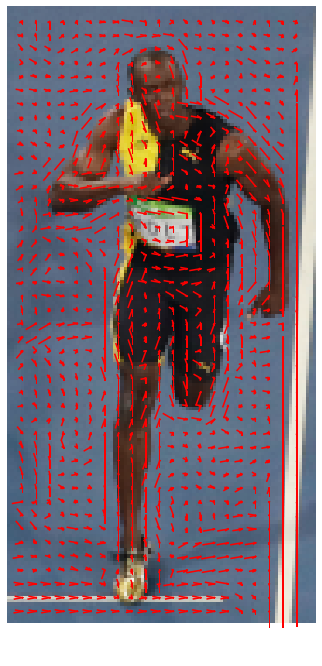

In [88]:
img = cv2.imread(drive_address + 'Data/bolt.png')
h = HOG(img, resize = (img.shape[0], img.shape[1]), _cellSize = (4, 4))
plt.figure(figsize = (15, 12))
visualize_HOG(img, h, 4, 2, num_bins = 9)

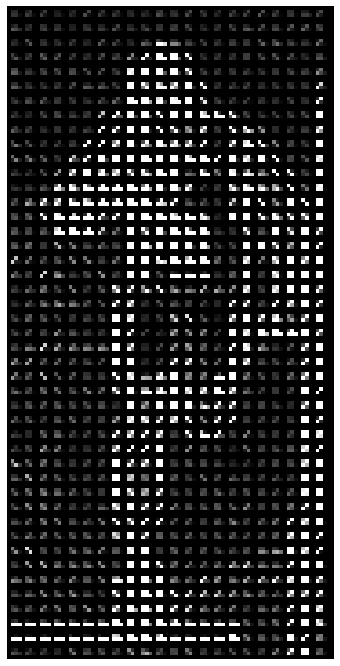

In [89]:
fd, hog_image = hog(img, visualize=True, orientations = 9,
                    pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2))

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize = (15, 12))
plt.axis('off')
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.show()  

In [89]:
# Loading Dataset



positive_patches = []
negative_patches = []

for i in range(1, 5970):
    print(i)
    img = cv2.imread(drive_address + "Data/vehicles/" + str(i) + ".png")
    if np.sum(img) == None:
        continue
    else:
        positive_patches.append(img)

for i in range(974):
    if i <= 9:
        img = cv2.imread(drive_address + "Data/vehicles/image000" + str(i) + ".png")
        if np.sum(img) == None:
            continue
        positive_patches.append(img)
        continue
    
    if i <= 99:  
        img = cv2.imread(drive_address + "Data/vehicles/image00" + str(i) + ".png")
        if np.sum(img) == None:
            continue
        positive_patches.append(img)
        continue
    
    img = cv2.imread(drive_address + "Data/vehicles/image0" + str(i) + ".png")
    if np.sum(img) == None:
        continue
    else:
        positive_patches.append(img)

for i in range(1, 5767):
    img = cv2.imread(drive_address + "Data/non-vehicles/extra" + str(i) + ".png")
    if np.sum(img) == None:
        continue
    else:
        negative_patches.append(img)

for i in range(1, 3901):
    img = cv2.imread(drive_address + "Data/non-vehicles/image" + str(i) + ".png")
    if np.sum(img) == None:
        continue
    else:
        negative_patches.append(img)

In [26]:
# positive_patches = np.load(drive_address + 'positive.npy')
# negative_patches = np.load(drive_address + 'negative.npy')

Augment = []
for i in range(positive_patches.shape[0]):
  Augment.append(positive_patches[i][:, ::-1, :])
positive_patches = np.append(positive_patches, np.array(Augment), axis = 0)

Augment = []
for i in range(negative_patches.shape[0]):
  Augment.append(negative_patches[i][:, ::-1, :])
negative_patches = np.append(negative_patches, np.array(Augment), axis = 0)
Augment = []


In [89]:
# Extracting HOG features

HOG_features = pd.DataFrame()
for i in range(len(positive_patches)):
  fd = hog(positive_patches[i], pixels_per_cell = (8, 8), cells_per_block = (3, 3), orientations = 9)  
  fd = fd.reshape((1, fd.shape[0]))
  HOG_features = pd.concat([HOG_features, pd.DataFrame(fd)], axis = 0, ignore_index = True)

for i in range(len(negative_patches)):
  fd = hog(negative_patches[i], pixels_per_cell = (8, 8), cells_per_block = (3, 3), orientations = 9)
  fd = fd.reshape((1, fd.shape[0]))
  HOG_features = pd.concat([HOG_features, pd.DataFrame(fd)], axis = 0, ignore_index = True)


In [89]:
# Labling datasets

labels = np.zeros(HOG_features.shape[0])
labels[:len(positive_patches)] = 1

In [30]:
# Splitting train and test sets

X_train, X_test, y_train, y_test = train_test_split(HOG_features, labels,
                                                    test_size = 0.2, random_state = 42)
X_train.reset_index(inplace = True)
X_train = X_train[X_train.columns[1:]]

X_test.reset_index(inplace = True)
X_test = X_test[X_test.columns[1:]]

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


************* SVM *************
Best: 0.982316 using {'C': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


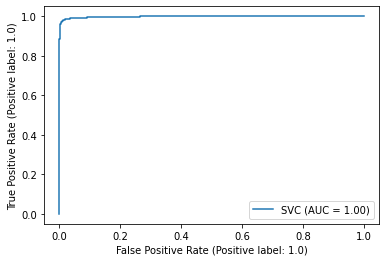

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     14349
         1.0       0.99      0.98      0.98     11103

    accuracy                           0.98     25452
   macro avg       0.98      0.98      0.98     25452
weighted avg       0.98      0.98      0.98     25452



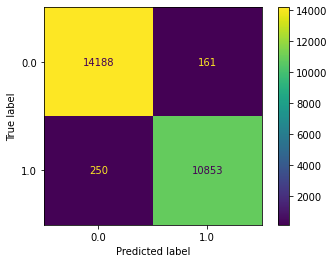

Train Accuracy:  99.3949394939494
Test Accuracy:  98.52294154619736


In [ ]:
# Learning SVM classifier based on cross validation and gridsearch
# 3*3 8*8 + augmentation
param_grid_SVM = {'C' : [0.01, 0.1, 1]}                  
clf = SVM_Grid_Search(param_grid_SVM, "f1", X_train, y_train)
y_predict = clf.predict(X_train)
print("Train Accuracy: ", np.mean(y_predict == y_train) * 100)    
y_predict = clf.predict(X_test)
print("Test Accuracy: ", np.mean(y_predict == y_test) * 100)

In [32]:
# Saving Model
pickle.dump(clf, open(drive_address + "SVM_model", 'wb'))

In [66]:
# Loading Model
clf = pickle.load(open(drive_address + "SVM_model", 'rb'))

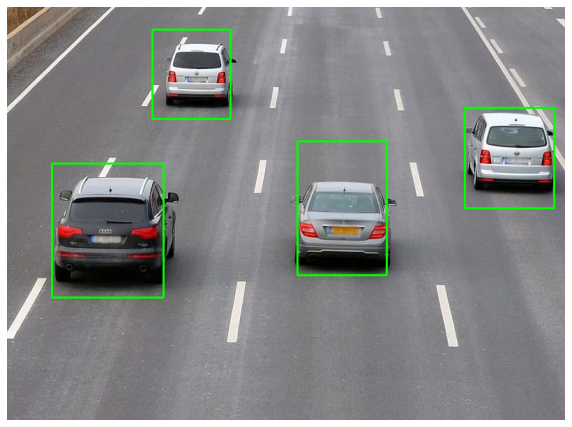

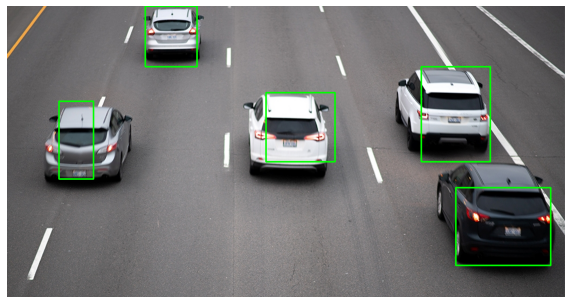

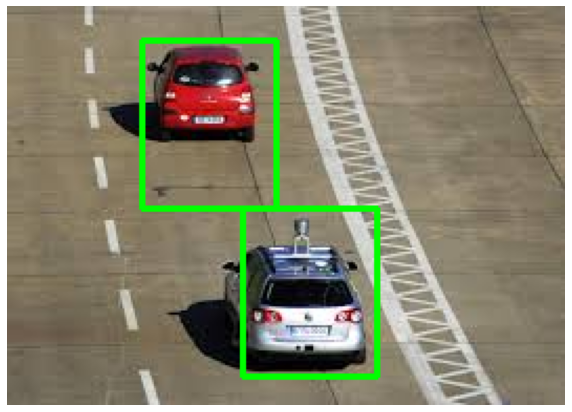

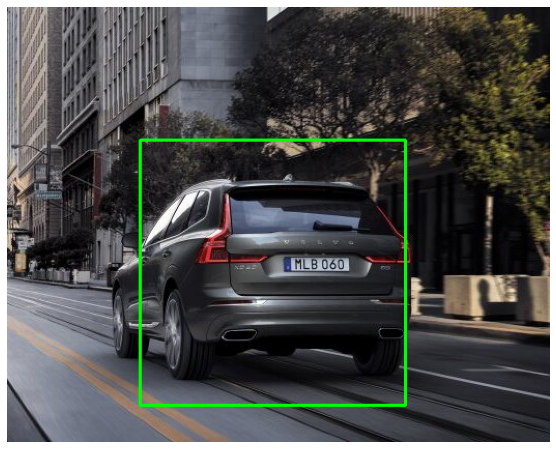

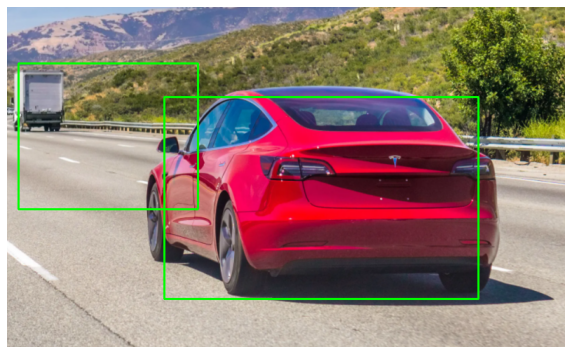

In [70]:
# Test Results

image = cv2.imread(drive_address + "/Data/test_images/test_img_1.jpg")
img = Car_Detection(image, clf, Pyramid_Level = 4, probability_threshold = 0.8,
                    h1 = 60, h2 = 64, threshold1 = 4, threshold2 = 0.01, threshold3 = -1)
cv2.imwrite(drive_address + "Test1.jpg", img)
plt.figure(figsize = (10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image = cv2.imread(drive_address + "/Data/test_images/test_img_2.jpg")
img = Car_Detection(image, clf, Pyramid_Level = 4, probability_threshold = 0.8,
                    h1 = 100, h2 = 64, threshold1 = 1, threshold2 = 0.1, threshold3 = 1)
cv2.imwrite(drive_address + "Test2.jpg", img)
plt.figure(figsize = (10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image = cv2.imread(drive_address + "/Data/test_images/test_img_3.jpg")
img = Car_Detection(image, clf, Pyramid_Level = 4, probability_threshold = 0.8,
                    h1 = 100, h2 = 60, threshold1 = 2, threshold2 = 0.01, threshold3 = -1)
cv2.imwrite(drive_address + "Test3.jpg", img)
plt.figure(figsize = (10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image = cv2.imread(drive_address + "/Data/test_images/test_img_4.jpg")
img = Car_Detection(image, clf, Pyramid_Level = 4, probability_threshold = 0.96,
                    h1 = 20, h2 = 50, threshold1 = 1, threshold2 = 0.01, threshold3 = 6, adaptive_box = False)
cv2.imwrite(drive_address + "Test4.jpg", img)
plt.figure(figsize = (10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image = cv2.imread(drive_address + "/Data/test_images/test_img_5.png")
img = Car_Detection(image, clf, Pyramid_Level = 5, probability_threshold = 0.9,
                    h1 = 150, h2 = 200, threshold1 = 3, threshold2 = 0.01, threshold3 = 2)
cv2.imwrite(drive_address + "Test5.jpg", img)
plt.figure(figsize = (10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

